In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import sklearn
import pickle

In [4]:
# load all models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
model_svm = pickle.load(open('./model/model_svm.pickle',mode='rb'))
pca_models = pickle.load(open('./model/pca_dict.pickle','rb'))

In [6]:
model_pca = pca_models['pca']
mean_face_arr = pca_models['mean_face']

# Creating pipeline

In [49]:
# step-1 Read image
img = cv2.imread('./test.jpg')
# step-2 convret to gray scale
gray =  cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# step-3 crop the face using haar cascade classifier
faces = haar.detectMultiScale(gray,1.5,3)
predictions = []
for x,y,w,h in faces:
    roi = gray[y:y+h,x:x+h]
#     plt.imshow(roi,cmap='gray')
    # step-4 normalization 0-1
    roi = roi/255.0
    # step-5 resize image 100x100
    if roi.shape[1]>100:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
    else:
        roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
    # step-6 flattern 1x10000
    roi_reshape = roi_resize.reshape(1,10000)
    # step-7 substarct with mean
    roi_mean = roi_reshape - mean_face_arr
    # step-8 get eigen image
    eigen_image = model_pca.transform(roi_mean)
    # step-9 Eigne image for visualization
    eig_img = model_pca.inverse_transform(eigen_image)
    # step-10 pass to ml model (SVM) and get predictions
    result = model_svm.predict(eigen_image)
    prob_score = model_svm.predict_proba(eigen_image)
    prob_score_max = prob_score.max()
    # step-11 generate report
    text = "%s : %d"%("female" if result[0]!='male' else 'male',prob_score_max*100)
    print(text)
    # defining colors based on results
    if result[0]=='male':
        color=(255,255,0)
    else:
        color = (0,255,255)
    cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
    cv2.putText(img,text,(x,y),cv2.FONT_HERSHEY_PLAIN,0.8,(255,255,255),2)
    output = {
        'roi':roi,
        'eig_img':eig_img,
        'prediction_name':"female" if result[0]!='male' else 'male',
        'score':prob_score_max
    }
    predictions.append(output)
        
    

male : 59
male : 55
female : 51


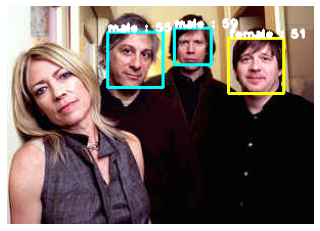

In [50]:
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img_rgb)

In [51]:
predictions

[{'roi': array([[0.06666667, 0.05098039, 0.08627451, ..., 0.14117647, 0.51764706,
          0.76862745],
         [0.06666667, 0.09411765, 0.03137255, ..., 0.06666667, 0.32156863,
          0.67843137],
         [0.11764706, 0.14509804, 0.02352941, ..., 0.05098039, 0.18823529,
          0.59607843],
         ...,
         [0.71764706, 0.64313725, 0.6627451 , ..., 0.00392157, 0.09803922,
          0.24705882],
         [0.77647059, 0.6745098 , 0.72156863, ..., 0.0627451 , 0.32941176,
          0.51764706],
         [0.80392157, 0.80392157, 0.79607843, ..., 0.02745098, 0.47058824,
          0.82745098]]),
  'eig_img': array([[-0.23003392, -0.23701655, -0.23935597, ..., -0.08368125,
          -0.07193411, -0.05624579]]),
  'prediction_name': 'male',
  'score': 0.5955523367197172},
 {'roi': array([[0.04705882, 0.13333333, 0.09411765, ..., 0.88627451, 0.89019608,
          0.83921569],
         [0.05098039, 0.11764706, 0.11372549, ..., 0.93333333, 0.95686275,
          0.88235294],
        

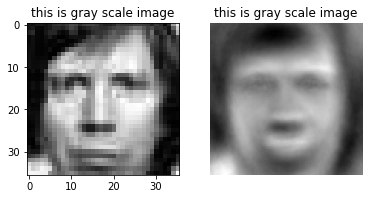

predicted Gender =  male
predicted Score = 59.56 %
----------------------------------------------------------------------------------------------------


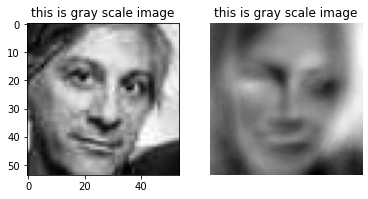

predicted Gender =  male
predicted Score = 55.08 %
----------------------------------------------------------------------------------------------------


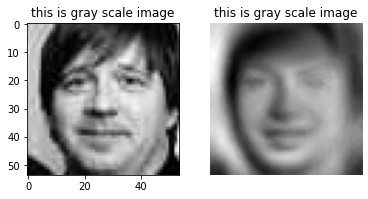

predicted Gender =  female
predicted Score = 51.51 %
----------------------------------------------------------------------------------------------------


In [57]:
# generate report
for i in range(len(predictions)):
    obj_gray = predictions[i]['roi']
    obj_eig = predictions[i]['eig_img'].reshape((100,100))
    plt.subplot(1,2,1)
    plt.imshow(obj_gray,cmap='gray')
    plt.title("this is gray scale image")
    plt.subplot(1,2,2)
    plt.imshow(obj_eig,cmap='gray')
    plt.title("this is gray scale image")
    plt.axis('off')
    plt.show()
    print("predicted Gender = ",predictions[i]["prediction_name"])
    print("predicted Score = {:,.2f} %".format(predictions[i]["score"]*100))
    print("-"*100)
    